In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# reading the data

train = pd.read_csv('training_data.csv')
test = pd.read_csv('testing_data.csv')

# getting the shapes
print("Shape of train :", train.shape)
print("Shape of test :", test.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'training_data.csv'

In [ ]:
# as both the dataset contains same columns we can combine them for better analysis

data = pd.concat([train, test])

# checking the shape
data.shape

(215063, 7)

In [8]:
# feature engineering
# let's make a new column review sentiment

data.loc[(data['rating'] >= 5), 'Review_Sentiment'] = 1
data.loc[(data['rating'] < 5), 'Review_Sentiment'] = 0

data['Review_Sentiment'].value_counts()

Review_Sentiment
1.0    161491
0.0     53572
Name: count, dtype: int64

In [9]:

# converting the date into datetime format
data['date'] = pd.to_datetime(data['date'], errors = 'coerce')

# now extracting year from date
data['Year'] = data['date'].dt.year

# extracting the month from the date
data['month'] = data['date'].dt.month

# extracting the days from the date
data['day'] = data['date'].dt.day

C:\Users\LENOVA\AppData\Local\Temp\ipykernel_30452\2467299954.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'], errors = 'coerce')


In [10]:
# we will delete the rows so that the data does not overfits

data = data.dropna(axis = 0)

# checking the new shape of the data
data.shape

(213869, 11)

In [11]:
# importing the important libraries 

import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [13]:
df_condition = data.groupby(['drugName'])['condition'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,drugName,condition
3647,Hydrocodone / ibuprofen,1
3648,Hydrochlorothiazide / moexipril,1
3649,Hepatitis b adult vaccine,1
3650,Hydrochlorothiazide / lisinopril,1
3651,Hetlioz,1
3652,Hexalen,1
3653,Hi-Vegi-Lip,1
3654,Hizentra,1
3655,Homatropine / hydrocodone,1
3656,Human papillomavirus vaccine,1


In [14]:
df_condition_1 = df_condition[df_condition['condition'] == 1].reset_index()

all_list = set(data.index)

# deleting them
condition_list = []
for i,j in enumerate(data['drugName']):
    for c in list(df_condition_1['drugName']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

In [15]:
# removing the conditions with <span> in it.
all_list = set(data.index)
span_list = []
for i,j in enumerate(data['condition']):
  if '</span>' in j:
    span_list.append(i)
new_idx = all_list.difference(set(span_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

In [16]:
# NLP
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [17]:
%time data['review_clean'] = data['review'].apply(review_to_words)

C:\Users\LENOVA\AppData\Local\Temp\ipykernel_30452\1027079973.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


CPU times: total: 31.5 s
Wall time: 1min 21s


In [18]:
# splitting the data into train and test

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size = 0.25, random_state = 0)

# checking the shape
print("Shape of train:", df_train.shape)
print("Shape of test: ", df_test.shape)

Shape of train: (106721, 12)
Shape of test:  (35574, 12)


In [19]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

cv = CountVectorizer(max_features = 20000, ngram_range = (4, 4))
pipeline = Pipeline([('vect',cv)])

df_train_features = pipeline.fit_transform(df_train['review_clean'])
df_test_features = pipeline.fit_transform(df_test['review_clean'])

print("df_train_features :", df_train_features.shape)
print("df_test_features :", df_test_features.shape)

df_train_features : (106721, 20000)
df_test_features : (35574, 20000)


In [20]:
# importing the libraries for deep learning model

import tensorflow as tf
import tensorflow_io as tfio

In [21]:
# making our dependent variable

y_train = df_train['Review_Sentiment']
y_test = df_test['Review_Sentiment']
solution = y_test.copy()

# Model Structure
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, input_shape=(20000,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(300),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               4000200   
                                                                 
 batch_normalization (Batch  (None, 200)               800       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               60300     
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                       

Epoch 1/10
3336/3336 [==============================] - 432s 127ms/step - loss: 0.5390 - accuracy: 0.7593
Epoch 2/10
3336/3336 [==============================] - 353s 106ms/step - loss: 0.4584 - accuracy: 0.7965
Epoch 3/10
3336/3336 [==============================] - 319s 96ms/step - loss: 0.4227 - accuracy: 0.8119
Epoch 4/10
3336/3336 [==============================] - 310s 93ms/step - loss: 0.4054 - accuracy: 0.8201
Epoch 5/10
3336/3336 [==============================] - 296s 89ms/step - loss: 0.3914 - accuracy: 0.8264
Epoch 6/10
3336/3336 [==============================] - 348s 104ms/step - loss: 0.3822 - accuracy: 0.8294
Epoch 7/10
3336/3336 [==============================] - 359s 108ms/step - loss: 0.3752 - accuracy: 0.8330
Epoch 8/10
3336/3336 [==============================] - 291s 87ms/step - loss: 0.3692 - accuracy: 0.8356
Epoch 9/10
3336/3336 [==============================] - 303s 91ms/step - loss: 0.3654 - accuracy: 0.8370
Epoch 10/10
3336/3336 [============================

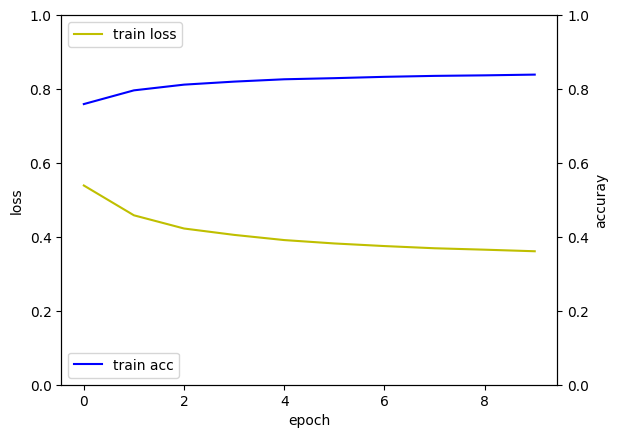

In [23]:
# 4. Train model
hist = model.fit(df_train_features.toarray(), y_train, epochs=10, batch_size=32)


# 5. Training process
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [24]:
test_sparse = tf.sparse.SparseTensor(
    indices=np.stack((df_test_features.tocoo().row, df_test_features.tocoo().col), axis=1),
    values=df_test_features.data,
    dense_shape=df_test_features.shape
)



In [25]:

# Reorder indices
test_sparse = tf.sparse.reorder(test_sparse)

# Make predictions
sub_preds_deep = model.predict(test_sparse, batch_size=32)


1112/1112 [==============================] - 2s 1ms/step


In [26]:
# !pip install lightgbm

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 1.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.3 MB 1.3 MB/s eta 0:00:01
   ------ --------------------------------- 0.2/1.3 MB 1.7 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.3 MB 2.4 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.3 MB 2.9 MB/s eta 0:00:01
   -------------------------------- ------- 1.1/1.3 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.2 MB/s eta 0:00:00


In [66]:
!pip show lightgbm

Name: lightgbm
Version: 3.3.0
Summary: LightGBM Python Package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (Microsoft)
Location: C:\Users\LENOVA\AppData\Roaming\Python\Python311\site-packages
Requires: numpy, scikit-learn, scipy, wheel
Required-by: 


In [69]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['Review_Sentiment']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
# clf.fit(trn_x, trn_y, 
#         eval_set= [(trn_x, trn_y), (val_x, val_y)], 
#         verbose=100, early_stopping_rounds=100  #30
#     )
clf.fit(trn_x, trn_y, eval_set=[(trn_x, trn_y), (val_x, val_y)])


sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [70]:
solution = df_test['Review_Sentiment']
confusion_matrix(y_pred = sub_preds, y_true = solution)

array([[    0,  8780],
       [    0, 26794]], dtype=int64)

In [71]:
!pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   - -------------------------------------- 30.7/626.3 kB ? eta -:--:--
   ------ --------------------------------- 102.4/626.3 kB 1.2 MB/s eta 0:00:01
   ------------- -------------------------- 204.8/626.3 kB 1.6 MB/s eta 0:00:01
   -------------------- ------------------- 327.7/626.3 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 2.8 MB/s eta 0:00:00


In [72]:
from textblob import TextBlob
from tqdm import tqdm
reviews = data['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
data["Predict_Sentiment"] = Predict_Sentiment
data.head()

100%|██████████| 142295/142295 [00:46<00:00, 3045.86it/s]


,,drugName,condition,review,rating,date,usefulCount,Review_Sentiment,Year,month,day,review_clean,Predict_Sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,1.0,2012,5,20,no side effect take combin bystol mg fish oil,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,1.0,2010,4,27,son halfway fourth week intuniv becam concern ...,0.114583
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1.0,2009,12,14,use take anoth oral contracept pill cycl happi...,0.105000
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,1.0,2016,11,27,suboxon complet turn life around feel healthie...,0.147037
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,2015-11-28,43,0.0,2015,11,28,nd day mg start work rock hard erect howev exp...,-0.013889


In [73]:
# checking the corrcoef between predict sentiment and rating

np.corrcoef(data["Predict_Sentiment"], data["rating"])

array([[1.        , 0.25507843],
       [0.25507843, 1.        ]])

In [74]:
# checking the corrcoef between predict sentiment and sentiment

np.corrcoef(data["Predict_Sentiment"], data["Review_Sentiment"])

array([[1.        , 0.22643043],
       [0.22643043, 1.        ]])

In [75]:
# predict sentiment 2

reviews = data['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
data["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 142295/142295 [02:05<00:00, 1133.40it/s]


In [76]:
data.head()

,,drugName,condition,review,rating,date,usefulCount,Review_Sentiment,Year,month,day,review_clean,Predict_Sentiment,Predict_Sentiment2
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,1.0,2012,5,20,no side effect take combin bystol mg fish oil,0.000000,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,1.0,2010,4,27,son halfway fourth week intuniv becam concern ...,0.114583,0.168333
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1.0,2009,12,14,use take anoth oral contracept pill cycl happi...,0.105000,0.067210
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,1.0,2016,11,27,suboxon complet turn life around feel healthie...,0.147037,0.194444
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,2015-11-28,43,0.0,2015,11,28,nd day mg start work rock hard erect howev exp...,-0.013889,0.003472


In [77]:
# checkingg correlation between predict statement2 and rating

np.corrcoef(data["Predict_Sentiment2"], data["rating"])


array([[1.        , 0.34698703],
       [0.34698703, 1.        ]])

In [78]:
# checking correlation between predict statement2 and sentiment

np.corrcoef(data["Predict_Sentiment2"], data["Review_Sentiment"])

array([[1.        , 0.30523853],
       [0.30523853, 1.        ]])

In [79]:
# FEATURE ENGINEERING

# word count in each unclean comment
data['count_sent'] = data["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

# Word count in each comment:
data['count_word'] = data["review_clean"].apply(lambda x: len(str(x).split()))

# Unique word count
data['count_unique_word'] = data["review_clean"].apply(lambda x: len(set(str(x).split())))

# Letter count
data['count_letters'] = data["review_clean"].apply(lambda x: len(str(x)))

# punctuation count
import string
data["count_punctuations"] = data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# upper case words count
data["count_words_upper"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# title case words count
data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Number of stopwords
data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

# Average length of the words
data["mean_word_len"] = data["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# adding season
data['season'] = data["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [81]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['Review_Sentiment']
feats = ['usefulCount']
trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
clf.fit(trn_x, trn_y,  eval_set= [(trn_x, trn_y), (val_x, val_y)])

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [82]:
solution = df_test['Review_Sentiment']
print(clf.score(df_test[feats],solution))
confusion_matrix(y_pred=sub_preds, y_true=solution)

0.7531905324113116


array([[    0,  8780],
       [    0, 26794]], dtype=int64)

In [83]:
# Dictionary_Sentiment_Analysis
# Because the package used for prediction of 'Predict value' is formed with movie review data, it can be unsuitable for this project which analyzes reviews
# for drugs. To make up for this, we conducted additional emotional analysis using the Harvard emotional dictionary.

# import dictionary data
word_table = pd.read_csv("inquirerbasic.csv")

# checking the head of the dictionary
word_table.head(10)

,Entry,Source,Positiv,Negativ
0,A,H4Lvd,NaN,NaN
1,ABANDON,H4Lvd,NaN,Negativ
2,ABANDONMENT,H4,NaN,Negativ
3,ABATE,H4Lvd,NaN,Negativ
4,ABATEMENT,Lvd,NaN,NaN
5,ABDICATE,H4,NaN,Negativ
6,ABHOR,H4,NaN,Negativ
7,ABIDE,H4,Positiv,NaN
8,ABILITY,H4Lvd,Positiv,NaN
9,ABJECT,H4,NaN,Negativ


In [84]:
# make list of sentiment
#Positiv word list   

temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list) 

1637

In [85]:
#Negativ word list 

temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)

2006

In [86]:
##2. counting the word 98590

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

In [87]:
# decide sentiment
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"])
df_test["sentiment_by_dic"] = df_test["Positiv_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head()

,,drugName,condition,review,rating,date,usefulCount,Review_Sentiment,Year,month,day,review_clean,num_Positiv_word,num_Negativ_word,Positiv_ratio,sentiment_by_dic
92236,186842,Fexofenadine / pseudoephedrine,Allergic Rhinitis,"""Allergra D, is the best medicine for my aller...",9,2009-07-10,18,1.0,2009,7,10,allergra best medicin allergi taken everi coun...,NaN,NaN,NaN,0.5
138379,21252,Focalin XR,ADHD,"""I have tried every ADHD drug medication avail...",10,2017-04-28,12,1.0,2017,4,28,tri everi adhd drug medic avail brand generic ...,NaN,NaN,NaN,0.5
86591,198835,Depo-Provera,Abnormal Uterine Bleeding,"""I took the shot for about a year but had to c...",1,2016-08-25,3,0.0,2016,8,25,took shot year come due medic problem shot ble...,NaN,NaN,NaN,0.5
17229,223944,Levonorgestrel,Emergency Contraception,"""It worked for me! I am 210 pounds and it work...",10,2016-12-08,7,1.0,2016,12,8,work pound work week ago condom fell without k...,1.0,6.0,0.142857,0.0
109781,98036,Nexplanon,Birth Control,"""I wanted this to work out so badly, since it ...",3,2015-08-21,4,0.0,2015,8,21,want work bad sinc effect birth control toler ...,NaN,NaN,NaN,0.5


In [88]:
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data, grouped, on='condition', how='left')
    return data

df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [89]:
df_test['deep_pred'] = sub_preds_deep
df_test['machine_pred'] = sub_preds

df_test['total_pred'] = (df_test['deep_pred'] + df_test['machine_pred'] + df_test['sentiment_by_dic'])*df_test['usefulCount']

In [90]:
df_test = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})
df_test

total_pred
                                                                mean
condition                 drugName                                  
ADHD                      Adderall                          0.166276
                          Adderall XR                       0.103549
                          Amphetamine                       0.020527
                          Amphetamine / dextroamphetamine   0.096934
                          Armodafinil                       0.008675
...                                                              ...
mulation) (phenylephrine) Phenylephrine                     6.671322
ungal Pneumonia           Fluconazole                       4.969722
von Willebrand's Disease  Stimate                           5.156916
zen Shoulde               Diclofenac                       14.980756
                          Voltaren                         36.692269

[3825 rows x 1 columns]

In [91]:
df_test.head(36)

total_pred
                                                    mean
condition drugName                                      
ADHD      Adderall                              0.166276
          Adderall XR                           0.103549
          Amphetamine                           0.020527
          Amphetamine / dextroamphetamine       0.096934
          Armodafinil                           0.008675
          Atomoxetine                           0.095370
          Bupropion                             0.175926
          Clonidine                             0.133089
          Concerta                              0.117147
          Daytrana                              0.050241
          Desoxyn                               0.229514
          Dexedrine                             0.204249
          Dexmethylphenidate                    0.089263
          Dextroamphetamine                     0.058090
          Evekeo                                0.036870
          Focalin                               0.095035
          Focalin XR                            0.108108
          Guanfacine                            0.119767
          Imipramine                            0.066511
          Intuniv                               0.176269
          Lisdexamfetamine                      0.095792
          Metadate CD                           0.136111
          Methamphetamine                       0.154647
          Methylin                              0.044746
          Methylphenidate                       0.090468
          Modafinil                             0.172890
          Nuvigil                               0.101992
          Omega-3 polyunsaturated fatty acids   0.199532
          Pristiq                               0.053434
          Ritalin                               0.103150
          Selegiline                            0.049160
          Strattera                             0.079632
          Vyvanse                               0.084333
          Wellbutrin                            0.284290
          Wellbutrin SR                         0.533895
          Wellbutrin XL                         0.178912

In [92]:
sorted_df = df_test.sort_values(('total_pred', 'mean'), ascending=False)


In [93]:
sorted_df.head(40)

,,total_pred
,,mean
condition,drugName,
Glioblastoma Multiforme,Avastin,230.939824
Scabies,Permethrin,190.132668
Gastric Ulcer Maintenance Treatment,Zantac,151.216625
Hypotension,Midodrine,135.650208
Premature Ventricular Depolarizations,Bisoprolol,134.044316
Endoscopy or Radiology Premedication,Valium,128.506607
Body Dysmorphic Disorde,Fluoxetine,127.497033
Mild Cognitive Impairment,Aricept ODT,126.755112


In [107]:
def get_drug_by_condition(sorted_df, condition):
    # get predicted values for the condition
    condition_df = sorted_df.loc[condition]
    # get drug with highest predicted value
    drug = condition_df[condition_df == condition_df.max()].index.get_level_values('drugName')[0]
    return drug

# example usage
condition=input("Please enter condition:")
drug = get_drug_by_condition(sorted_df, condition)
print(f"Drug with highest predicted value for condition '{condition}': {drug}")

Drug with highest predicted value for condition 'Scabies': Permethrin
